<a href="https://colab.research.google.com/github/jeremysb1/predictive-analytics/blob/main/matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries, Directory, and Data

In [ ]:
#install library
!pip install pandas==1.2.0
!pip install CausalInference

In [2]:
#Directory
%cd /content/drive/MyDrive/Business Analyst Course/Econometrics and Causal Inference/Matching

/content/drive/MyDrive/Business Analyst Course/Econometrics and Causal Inference/Matching


In [3]:
#libraries
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as ss
from causalinference import CausalModel

In [4]:
#Data
df = pd.read_csv("school.csv")
df = df.iloc[:,1:]
df.head()

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378
2,0,"WHITE, NON-HISPANIC",1,43,55,"MASTER'S DEGREE (MA, MS)",GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,63.43,53.5,62500.5,0,0,0.490611
3,1,"WHITE, NON-HISPANIC",1,38,39,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,53.50,53.5,87500.5,0,0,1.451278
4,0,"WHITE, NON-HISPANIC",1,47,57,DOCTORATE OR PROFESSIONAL DEGREE,"MASTER'S DEGREE (MA, MS)",61.56,77.5,150000.5,0,0,2.595699


#Data Analysis

In [5]:
#Comparing groups
df.groupby('catholic').mean()

,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized
catholic,,,,,,,,,
0,1.106246,37.794621,40.134919,43.909495,42.590520,65393.928540,0.101578,0.045566,0.163128
1,1.073118,39.775269,42.007527,47.620871,45.908269,86180.625269,0.016129,0.006452,0.219685


In [6]:
#t-test
group1 = df.where(df.catholic == 0).dropna()["income"]
group2 = df.where(df.catholic == 1).dropna()["income"]
stat, p = ss.ttest_ind(group1, group2)
print(p)

5.943636213205364e-41


In [7]:
#t-test loop
continuous = ["number_places_lived", "mom_age", "dad_age",
              "mom_score", "dad_score", "income"]

#Where to store the results
stat = {}
p = {}

#Loop
for x in continuous:
  group1 = df.where(df.catholic == 0).dropna()[x]
  group2 = df.where(df.catholic == 1).dropna()[x]
  stat[x], p[x] = ss.ttest_ind(group1, group2)
ttests = pd.DataFrame.from_dict(p, orient = "Index")
ttests.columns = ["pvalue"]
print(ttests)

                           pvalue
number_places_lived  7.072609e-03
mom_age              1.359492e-22
dad_age              3.344265e-16
mom_score            2.280116e-19
dad_score            5.489722e-18
income               5.943636e-41


In [8]:
#chi-sqaure test
tab = pd.crosstab(index = df.poverty,
                  columns = df.catholic)
statistic, p, dof, exp = ss.chi2_contingency(tab)
print(p)

6.511354893726035e-17


In [9]:
#what to loop
categorical = ["poverty", "food_stamps"]

#where to store 
statistic = {}
p = {}
dof = {}
exp = {}

#loop
for x in categorical:
  tab = pd.crosstab(index = df[x],
                    columns = df.catholic)
  statistic[x], p[x], dof[x], exp[x] = ss.chi2_contingency(tab)
chisquare = pd.DataFrame.from_dict(p, orient = "Index")
chisquare.columns = ["pvalue"]
print(chisquare)

                   pvalue
poverty      6.511355e-17
food_stamps  3.294153e-08


#Matching Prep

In [10]:
#Temporary dataframe
temp = pd.get_dummies(df)
temp.head(1)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,...,dad_education_VOC/TECH PROGRAM,mom_education_8TH GRADE OR BELOW,mom_education_9TH - 12TH GRADE,mom_education_BACHELOR'S DEGREE,mom_education_DOCTORATE OR PROFESSIONAL DEGREE,mom_education_GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,mom_education_HIGH SCHOOL DIPLOMA/EQUIVALENT,"mom_education_MASTER'S DEGREE (MA, MS)",mom_education_SOME COLLEGE,mom_education_VOC/TECH PROGRAM
0,0,1,47,45,53.5,77.5,62500.5,0,0,0.981753,...,0,0,0,0,0,0,0,0,1,0


In [11]:
#check race data
df.race.value_counts()

WHITE, NON-HISPANIC                        3654
HISPANIC, RACE NOT SPECIFIED                408
HISPANIC, RACE SPECIFIED                    387
BLACK OR AFRICAN AMERICAN, NON-HISPANIC     357
ASIAN                                       342
MORE THAN ONE RACE, NON HISPANIC            123
NATIVE HAWAIIAN, OTHER PACIFIC ISLANDER      93
AMERICAN INDIAN OR ALASKA NATIVE             62
NOT ASCERTAINED                               3
Name: race, dtype: int64

In [12]:
#Preparing race variable
df[["race_asian"]] = np.where(df.race == 'ASIAN', 1, 0)
df[["race_white"]] = np.where(df.race == 'WHITE, NON-HISPANIC', 1, 0)
df[["race_black"]] = np.where(df.race == 'BLACK OR AFRICAN AMERICAN, NON-HISPANIC', 1, 0)
df[["race_hispanic"]] = np.where((df.race == 'HISPANIC, RACE NOT SPCIFIED') |
                              (df.race == 'HISPANIC, RACE SPECIFIED'), 1, 0)
df.head()

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_asian,race_white,race_black,race_hispanic
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.50,77.5,62500.5,0,0,0.981753,0,1,0,0
1,0,"WHITE, NON-HISPANIC",1,41,48,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,34.95,53.5,45000.5,0,0,0.594378,0,1,0,0
2,0,"WHITE, NON-HISPANIC",1,43,55,"MASTER'S DEGREE (MA, MS)",GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,63.43,53.5,62500.5,0,0,0.490611,0,1,0,0
3,1,"WHITE, NON-HISPANIC",1,38,39,BACHELOR'S DEGREE,GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE,53.50,53.5,87500.5,0,0,1.451278,0,1,0,0
4,0,"WHITE, NON-HISPANIC",1,47,57,DOCTORATE OR PROFESSIONAL DEGREE,"MASTER'S DEGREE (MA, MS)",61.56,77.5,150000.5,0,0,2.595699,0,1,0,0


In [13]:
#Education variable
df.dad_education.value_counts()

HIGH SCHOOL DIPLOMA/EQUIVALENT            1524
SOME COLLEGE                              1344
BACHELOR'S DEGREE                         1026
9TH - 12TH GRADE                           355
MASTER'S DEGREE (MA, MS)                   354
VOC/TECH PROGRAM                           306
DOCTORATE OR PROFESSIONAL DEGREE           224
8TH GRADE OR BELOW                         167
GRADUATE/PROFESSIONAL SCHOOL-NO DEGREE     129
Name: dad_education, dtype: int64

In [14]:
#Transforming education variable
df[["dad_higher_education"]] = np.where((df.dad_education == "BACHELOR'S DEGREE") |
                                        (df.dad_education == "DOCTORATE OR PROFESSIONAL DEGREE") |
                                        (df.dad_education == "MASTER'S DEGREE (MA, MS)"),
                                        1, 0)
df[["mom_higher_education"]] = np.where((df.mom_education == "BACHELOR'S DEGREE") |
                                        (df.mom_education == "DOCTORATE OR PROFESSIONAL DEGREE") |
                                        (df.mom_education == "MASTER'S DEGREE (MA, MS)"),
                                        1, 0)
df.head(1)

,catholic,race,number_places_lived,mom_age,dad_age,dad_education,mom_education,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_asian,race_white,race_black,race_hispanic,dad_higher_education,mom_higher_education
0,0,"WHITE, NON-HISPANIC",1,47,45,DOCTORATE OR PROFESSIONAL DEGREE,SOME COLLEGE,53.5,77.5,62500.5,0,0,0.981753,0,1,0,0,1,0


In [15]:
#Cleaning dataset
df = df.drop(columns = ["race", "dad_education", "mom_education"])
df.head(1)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_asian,race_white,race_black,race_hispanic,dad_higher_education,mom_higher_education
0,0,1,47,45,53.5,77.5,62500.5,0,0,0.981753,0,1,0,0,1,0


In [16]:
#Isolate y, treatment, and confounders
treat = df.catholic.values
y = df.score_standardized.values
confounders = df.drop(columns = ["catholic", "score_standardized"]).values

#Common Support Regions

In [18]:
#Logistic Regression
import statsmodels.api as sm
confounders_csr = sm.add_constant(confounders)
csr_model = sm.Logit(treat, confounders_csr).fit()
print(csr_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.431304
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5429
Model:                          Logit   Df Residuals:                     5414
Method:                           MLE   Df Model:                           14
Date:                Sun, 13 Mar 2022   Pseudo R-squ.:                 0.05818
Time:                        13:10:05   Log-Likelihood:                -2341.5
converged:                       True   LL-Null:                       -2486.2
Covariance Type:            nonrobust   LLR p-value:                 2.032e-53
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.0409      0.382    -10.582      0.000      -4.789      -3.292
x1            -0.1643      0.

In [19]:
#checking correlation in the confounders group
df.drop(columns = ["catholic", "score_standardized"]).corr()

,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,race_asian,race_white,race_black,race_hispanic,dad_higher_education,mom_higher_education
number_places_lived,1.000000,-0.105116,-0.096571,-0.042976,-0.033342,-0.039007,0.058450,0.063574,0.030205,-0.030456,-0.004143,0.000166,-0.022836,-0.045230
mom_age,-0.105116,1.000000,0.741862,0.224808,0.237727,0.276373,-0.134362,-0.106739,0.052270,0.098262,-0.060004,-0.062116,0.265912,0.281417
dad_age,-0.096571,0.741862,1.000000,0.179047,0.197057,0.222995,-0.100600,-0.083560,0.085816,0.063543,-0.039396,-0.061446,0.247213,0.213065
mom_score,-0.042976,0.224808,0.179047,1.000000,0.309380,0.361271,-0.190873,-0.111281,-0.015435,0.155196,-0.033081,-0.087782,0.324952,0.458104
dad_score,-0.033342,0.237727,0.197057,0.309380,1.000000,0.406067,-0.172984,-0.113052,0.029000,0.144808,-0.075754,-0.079089,0.467236,0.321471
income,-0.039007,0.276373,0.222995,0.361271,0.406067,1.000000,-0.369395,-0.214107,-0.005106,0.247893,-0.119058,-0.097721,0.440927,0.397905
poverty,0.058450,-0.134362,-0.100600,-0.190873,-0.172984,-0.369395,1.000000,0.387830,0.046462,-0.267137,0.092218,0.115239,-0.168300,-0.157597
food_stamps,0.063574,-0.106739,-0.083560,-0.111281,-0.113052,-0.214107,0.387830,1.000000,-0.005068,-0.150369,0.108143,0.018368,-0.105153,-0.105883
race_asian,0.030205,0.052270,0.085816,-0.015435,0.029000,-0.005106,0.046462,-0.005068,1.000000,-0.372021,-0.068790,-0.071835,0.089660,0.075650
race_white,-0.030456,0.098262,0.063543,0.155196,0.144808,0.247893,-0.267137,-0.150369,-0.372021,1.000000,-0.380653,-0.397502,0.105363,0.130682


In [20]:
#Predictions
probabilities = csr_model.predict(confounders_csr)
probabilities

array([0.25765823, 0.17221318, 0.24398578, ..., 0.23222606, 0.11974837,
       0.1791046 ])

In [22]:
#Create dataframe with probabilities and being treated or not
df_prob = np.vstack([treat, probabilities])
df_prob = np.transpose(df_prob)
df_prob

array([[0.        , 0.25765823],
       [0.        , 0.17221318],
       [0.        , 0.24398578],
       ...,
       [0.        , 0.23222606],
       [0.        , 0.11974837],
       [0.        , 0.1791046 ]])

In [28]:
#split between treated and non-treated
non_treated = df_prob[:, 0] == 0
non_treated = df_prob[non_treated]
non_treated = non_treated[:, 1]
treated = df_prob[:, 0] == 1
treated = df_prob[treated]
treated = treated[:, 1]

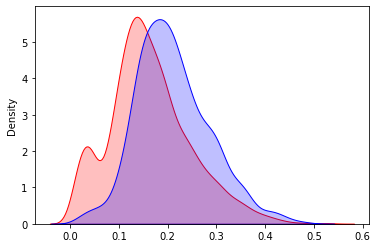

In [29]:
#Common Support Region
plot_non_treated = sns.kdeplot(non_treated, shade = True, color = 'r')
plot_treated = sns.kdeplot(treated, shade = True, color = 'b')

#Matching

In [31]:
#Matching Model
model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj=True)
print(model.estimates)

/usr/local/lib/python3.7/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef



Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.133      0.063     -2.116      0.034     -0.256     -0.010
           ATC     -0.122      0.070     -1.752      0.080     -0.259      0.014
           ATT     -0.185      0.060     -3.101      0.002     -0.302     -0.068



#Robustness:  Repeated Experiments

In [35]:
#how to get the results
model.estimates['matching']['ate']

-0.1329681287399786

In [ ]:
#prepare for the loop

ate = {}
i = 0

#start the loop

while i < 1000:
  #sample
  sample = df.sample(1000)

  #matching preparation
  treat = sample.catholic.values
  confounders = sample.drop(columns = ["catholic", "score_standardized"]).values
  y = sample.score_standardized.values
  
  #matching
  model = CausalModel(y, treat, confounders)
  model.est_via_matching(bias_adj=True)

  #store the results
  ate[i] = model.estimates['matching']['ate']
  i += 1
  print(i)

AxesSubplot(0.125,0.125;0.775x0.755)
-0.12808380426769053


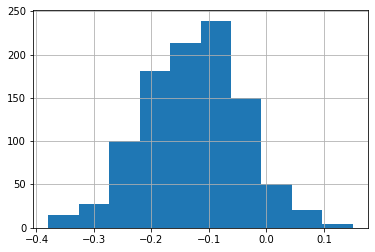

In [38]:
#Vizualization
ate = pd.Series(ate)
print(ate.hist())
print(ate.mean())

#Robustness Check:  Removing 1 Confounder

In [42]:
#New Confounder List
confounder = df.drop(columns = ["catholic", "score_standardized", "number_places_lived"]).values

In [43]:
df.head(0)

,catholic,number_places_lived,mom_age,dad_age,mom_score,dad_score,income,poverty,food_stamps,score_standardized,race_asian,race_white,race_black,race_hispanic,dad_higher_education,mom_higher_education


In [44]:
#Matching
model = CausalModel(y, treat, confounders)
model.est_via_matching(bias_adj=True)
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.143      0.145     -0.991      0.322     -0.427      0.140
           ATC     -0.101      0.157     -0.643      0.520     -0.410      0.207
           ATT     -0.347      0.149     -2.336      0.020     -0.639     -0.056



/usr/local/lib/python3.7/dist-packages/causalinference/estimators/matching.py:100: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return np.linalg.lstsq(X, Y)[0][1:]  # don't need intercept coef
